In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling2D, Flatten, Dense, Input, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [23]:
df = pd.read_csv('south_tweets.csv')
df.head()

,Timestamp,TweetText,Closest_State,Closest_City,Region
0,10229,i gotta get you readded to bbm,Alabama,Adamsville,South
1,16439,ahhh yes,Alabama,Adamsville,South
2,17131,an old locksmith,Alabama,Adamsville,South
3,2648,rt they are shooting at pentagon metro please...,Alabama,Adamsville,South
4,2750,as a matter of fact i wanna ask about that,Alabama,Adamsville,South


In [24]:
df.shape

(120735, 5)

In [25]:
df['TweetText'] = df['TweetText'].astype(str)

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['TweetText'].tolist())

In [27]:
df2 = df.copy()

In [28]:
cols = ['Closest_City','Region']
df2 = df2.drop(cols, axis = 1)

In [29]:
one_hot = pd.get_dummies(df2['Closest_State'])
df2 = df2.join(one_hot)
df2 = df2.drop('Closest_State', axis = 1)

In [30]:
df2

,Timestamp,TweetText,Alabama,Arkansas,Delaware,District of Columbia,Florida,Georgia,Kentucky,Louisiana,Maryland,Mississippi,North Carolina,South Carolina,Tennessee,Virginia,West Virginia
0,10229,i gotta get you readded to bbm,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,16439,ahhh yes,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,17131,an old locksmith,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2648,rt they are shooting at pentagon metro please...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2750,as a matter of fact i wanna ask about that,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120730,68496,ive been to wrigley field a few yrs ago every...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
120731,79377,heyyyyyyy the old spice dude is in this movie ...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
120732,8351,well u look good on that one fwiw lol,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
120733,11210,bedtime this whole weekend will be funnot really,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [31]:
x_dat = df2[['TweetText','Timestamp']]
y_dat = df2[df['Closest_State'].unique()]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_dat, y_dat, test_size = 0.3, random_state = 40)

In [33]:
x_dat["TweetText"].str.split(" ").str.len().describe(percentiles=[0.01, 0.5, 0.99])

count    120735.000000
mean         11.846134
std           7.486253
min           1.000000
1%            2.000000
50%          11.000000
99%          28.000000
max         710.000000
Name: TweetText, dtype: float64

In [34]:
tmax_length = 29

In [35]:
train_sequences = tokenizer.texts_to_sequences(x_train['TweetText'].tolist())
test_sequences = tokenizer.texts_to_sequences(x_test['TweetText'].tolist())

train_seq = pad_sequences(train_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')
test_seq = pad_sequences(test_sequences, maxlen = tmax_length, padding = 'post', truncating = 'post')

In [36]:
vocab_size = len(tokenizer.index_word) + 1
embedding_dim = 150

In [37]:
timestamps_train = x_train['Timestamp']
timestamps_test = x_test['Timestamp']

In [38]:
input_seq = Input(shape = (tmax_length,), name = 'Input Sequence')
input_time = Input(shape = (1,), name = "Input Timestamp")

embed = Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = tmax_length)(input_seq)
convol = Conv1D(filters = 128, kernel_size = 3, activation = 'relu')(embed)
maxpool = GlobalAveragePooling1D()(convol)

concat = Concatenate()([maxpool, input_time])
dense1 = Dense(50, activation = 'relu')(concat)
dense2 = Dense(15, activation = 'relu')(dense1)
output = Dense(len(df['Closest_State'].unique()), activation = 'sigmoid')(dense2)

model = Model(inputs = [input_seq, input_time], outputs = output)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Sequence      │ (None, 29)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 29, 150)   │ 12,160,500 │ Input             │
│ (Embedding)         │                   │            │ Sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 27, 128)   │     57,728 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input Timestamp     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 129)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ Input             │
│                     │                   │            │ Timestamp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50)        │      6,500 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 15)        │        765 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 15)        │        240 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,225,733 (46.64 MB)

 Trainable params: 12,225,733 (46.64 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit([train_seq, timestamps_train], y_train, epochs = 6, batch_size = 50, validation_data = ([test_seq, timestamps_test], y_test))

Epoch 1/6
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 127s 74ms/step - accuracy: 0.1374 - loss: 285.9119 - val_accuracy: 0.2148 - val_loss: 2.2950
Epoch 2/6
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 123s 73ms/step - accuracy: 0.2180 - loss: 2.2679 - val_accuracy: 0.2148 - val_loss: 2.2408
Epoch 3/6
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 124s 73ms/step - accuracy: 0.2145 - loss: 2.2405 - val_accuracy: 0.2148 - val_loss: 2.2367
Epoch 4/6
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 123s 72ms/step - accuracy: 0.2157 - loss: 2.2376 - val_accuracy: 0.2148 - val_loss: 2.2361
Epoch 5/6
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 122s 72ms/step - accuracy: 0.2156 - loss: 2.2390 - val_accuracy: 0.2148 - val_loss: 2.2360
Epoch 6/6
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 123s 73ms/step - accuracy: 0.2131 - loss: 2.2388 - val_accuracy: 0.2148 - val_loss: 2.2360


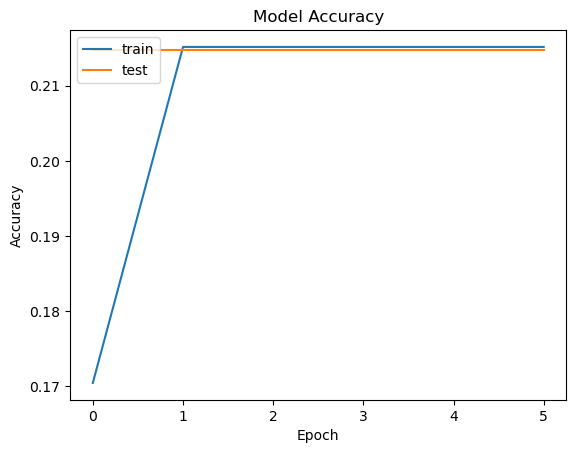

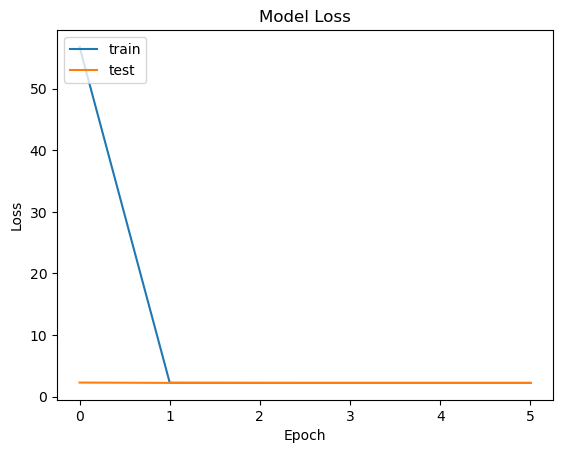

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()